Name: Mohammad Sadegh Majidi Yazdi

Student Number: 98106004


In [236]:
#dependencies
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

In [237]:
#load the input image
def load_img(image_name):
    img = cv2.imread(image_name)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    plt.imshow(img)
    img = np.asarray(img, dtype="int32")
    image_shape = img.shape
    image_pixels = np.reshape(img, (-1, img.shape[2]))
    return image_pixels, img.shape

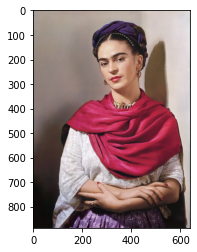

In [238]:
#write the name of your image here
image_name = 'test.png'
image, image_shape = load_img(image_name)

In [239]:
#determine number of desired classes here:
number_of_classes = 3

In [240]:
#Color each segment of your image. Add your desired colors in RGB format here, as an example:
#here number of desired classes for image segmentation is 3
colors = [
        (255, 0, 0),    # red
        (0, 255, 0),    # green
        (0, 0, 255),    # blue
        (245, 207, 37), # yellow
        (255, 36, 182),# purple
        # ...
    ]

<div dir="rtl">
    الگوریتم kmeans را به سبک kmeans++ می‌نویسیم.
</div>

In [241]:
#for better results, do the initializations with Kmeans 
def kmeans(number_of_classes, image_pixels):

    num_of_features = image_pixels.shape[1]
    c = np.zeros((number_of_classes, num_of_features))
    c[0] = random.choice(image_pixels)
    for j in range(1, number_of_classes):
        curr_c = c[:j]
        all_pairs_dist = (image_pixels**2).sum(1)[:,None] + (curr_c**2).sum(1) - 2*image_pixels.dot(curr_c.T)
        min_dists_to_centers = all_pairs_dist.min(axis=1)
        c[j] = random.choices(image_pixels, weights=min_dists_to_centers)[0]
        
    max_iteration = 1200
    predictions = None
    for i in range(max_iteration):
      data_center_dists = (image_pixels**2).sum(1)[:,None] + (c**2).sum(1) - 2*image_pixels.dot(c.T)
      predictions = data_center_dists.argmin(axis=1)

      cuur_centers = np.copy(c)

      for j in range(number_of_classes):
        cluster_j = image_pixels[predictions == j] 
        if len(cluster_j) > 0:
          c[j] = cluster_j.mean(axis=0)
      
      if (c == cuur_centers).all():
        break
        
    initial_mus = []
    initial_covs = []
    initial_priors = []
    
    for j in range(number_of_classes):
        cluster_j = image_pixels[predictions == j]
        initial_mus.append(cluster_j.mean(axis=0))
        initial_covs.append(np.cov(cluster_j, rowvar=False))
        initial_priors.append(np.divide(len(cluster_j), image_pixels.shape[0]))
        
    initial_mus = np.array(initial_mus)
    initial_covs = np.array(initial_covs)
    initial_priors = np.array(initial_priors)
    
    return initial_mus, initial_priors, initial_covs, predictions

<div dir="rtl">
مقدار distortion را با نوشتن یک تابع محاسبه می‌کنیم. الگوریتم را به ازای تعداد دسته‌های ۱ تا ۱۰ اجرا می‌کنیم و نمودار مقدار distortion را رسم می‌کنیم. مشاهده می‌کنیم که از ۵ به بعد مقدار نمودار تغییر محسوسی نمی‌کند. پس ۵ مقدار مناسبی برای تعداد دسته‌ها خواهد بود. 
</div>

1
2
3
4
5
6
7
8
9
10


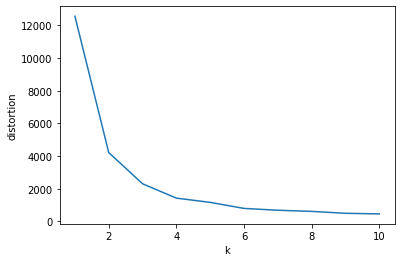

In [242]:
def calc_distortion(datas, predictions, centers, ncomp):
    distortion = 0

    for i in range(ncomp):
      cluster_x = datas[predictions == i]
      cluster_center = centers[i]
      if len(cluster_x) > 0:
        cluster_distances = (cluster_x**2).sum(1)[:,None] + (np.expand_dims(cluster_center, 0)**2).sum(1) - 2*cluster_x.dot(np.expand_dims(cluster_center, 0).T)

        distortion += cluster_distances.sum()
    
    return distortion / datas.shape[0]

distortions = np.zeros(10)
for i in range(1, 11):
    print(i)
    centers, ps, covs, preds = kmeans(i, image)
    distortions[i-1] = calc_distortion(image, preds, centers, i)
    
plt.plot(range(1, 11), distortions)

plt.xlabel('k')
plt.ylabel('distortion')
plt.show()

# assign appropriate k for number of classes
number_of_classes = 5

In [243]:
#for better results, observe the image histogram
def get_img_histogram(image_pixels):

    #your code here
    
    return number_of_classes, initial_mus, initial_priors, initial_covs

<div dir="rtl">
    الگوریتم
    EM برای مدل
    GMM
    را با گام‌های E و M
    کامل پیاده می‌کنیم.
</div>

In [244]:
import scipy
import scipy.stats
from scipy.stats import multivariate_normal 

class GMM:
    
    def __init__(self, number_of_classes, initial_mu_s, initial_sigma_s, initial_priors):
        self.ncomp = number_of_classes
        self.mu_s = np.asarray(initial_mu_s)
        self.sigma_s = np.asarray(initial_sigma_s)
        self.priors = np.asarray(initial_priors)
    
    
    # Write E step here
    def inference(self, datas):
        mv_pdf = self.multivariate_gaussian_pdf(datas).T
        beliefs = [mv_pdf[i]*self.priors[i] for i in range(self.ncomp)]
        return np.divide(beliefs, np.sum(beliefs, axis=0))
        
        
    # Write M step here
    def update(self, datas, beliefs):
        
        NKs = np.sum(beliefs, axis=1).reshape(-1, 1)
        N = np.sum(NKs)
        self.priors = np.array([np.divide(NKs[i], N) for i in range(self.ncomp)])
        self.mu_s = np.array([np.divide(np.sum(datas.T*beliefs[i], axis=1), NKs[i]) for i in range(self.ncomp)])
        self.sigma_s = np.array([np.divide(((datas-self.mu_s[i])*beliefs[i].reshape(-1, 1)).T @ (datas-self.mu_s[i]), NKs[i]) for i in range(self.ncomp)])
    
    
    def multivariate_gaussian_pdf(self, datas):
        n_samples, n_features = np.shape(datas)
        diff = np.reshape(datas, (n_samples, 1, n_features)) - np.reshape(self.mu_s, (1, self.ncomp, n_features))
        l = np.linalg.inv(self.sigma_s)
        exponent = np.einsum("nkj,nkj->nk", np.einsum("nki,kij->nkj", diff, l), diff)
        return np.exp(-0.5*exponent)/np.sqrt(np.linalg.det(self.sigma_s))/(2*np.pi)**(n_features/2)
    
    
    def calc_log_likelihood(self, datas):
        log_likelihood = np.sum(np.log(self.multivariate_gaussian_pdf(datas) @ self.priors))
        return log_likelihood
    
    
    def predict(self, datas):
        mv_pdf = self.multivariate_gaussian_pdf(datas).T
        beliefs = np.array([mv_pdf[i]*self.priors[i] for i in range(self.ncomp)])
        return np.argmax(beliefs, axis=0)
    
    
    def fit(self, datas, max_iteration, tresh):
        log_likelihood = - float("inf")
        
        for i in range(max_iteration):
            beliefs = self.inference(datas)
            self.update(datas, beliefs)
            log_likelihood_old = log_likelihood
            log_likelihood = self.calc_log_likelihood(datas)
            
            if  log_likelihood - log_likelihood_old < tresh:
                break
        

<div dir="rtl">
    ابتدا الگوریتم
    kmeans
    را با تعداد دسته ۵ اجرا می‌کنیم.
    پس از اتمام، برای هر دسته نهایی میانگین رنگ‌های نقاط آن دسته را به عوان میانگین اولیه،
    کوواریانس نقاط هر دسته را به عنوان کوواریانس اولیه و نسبت تعداد نقاط
    هر دسته به کل نقاط را به عنوان توزیع پیشینه به ورودی 
    GMM
    می‌دهیم.
    <br>
    نهایتا از نتایج به دست آمده هر گروه را به یکی از رنگ‌ها اساین می‌کنیم و برای هر نقطه
    دسته دارای بیشترین احتمال را به عنوان دسته نهایی معرفی می‌کنیم.
</div>

clusters:  [0 1 2 3 4]
number of points:  [133260  98736  84786 126090 124808]


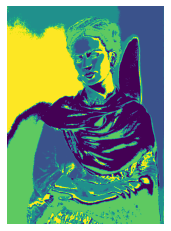

clusters:  [0 1 2 3 4]
number of points:  [100904  90163 227976  93135  55502]


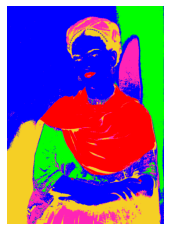

In [245]:
#write your main function here
#use of kmeans or histogram of the image for better initialization is optinal
#call the GMM functions here

# kmeans++
kmeans_result = kmeans(number_of_classes, image)
image_clustered = kmeans_result[3].reshape((image_shape[0], image_shape[1]))
print('clusters: ', np.unique(image_clustered, return_counts = True)[0])
print('number of points: ', np.unique(image_clustered, return_counts = True)[1])
plt.figure()
plt.imshow(image_clustered)
plt.axis('off')
plt.show()


# GMM
gmm_segment = GMM(number_of_classes, kmeans_result[0], kmeans_result[2], kmeans_result[1])
gmm_segment.fit(image, 15, 1e-4)
pred = gmm_segment.predict(image)
pred_colored = np.array([colors[i] for i in pred])
clustered_img = pred_colored.reshape(image_shape)
clustered_img_without_color = pred.reshape((image_shape[0], image_shape[1]))
print('clusters: ', np.unique(clustered_img_without_color, return_counts = True)[0])
print('number of points: ', np.unique(clustered_img_without_color, return_counts = True)[1])
plt.figure()
plt.imshow(clustered_img)
plt.axis('off')
plt.show()


In [246]:
#show and save your results
#let the final image variable be clustered_img
def save_img(clustered_img):
    plt.imshow(clustered_img)
    final_img = cv2.cvtColor(np.float32(clustered_img), cv2.COLOR_RGB2BGR)
    cv2.imwrite("result.jpg", final_img)

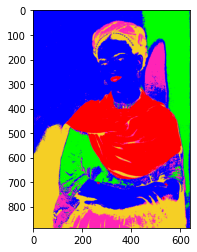

In [247]:
save_img(clustered_img)